In [3]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import numpy as np
from functools import reduce
from scipy.stats import mode

In [4]:
df_uyc = pd.read_csv("data/Usuariosyconsumodeelectricidadpormunicipio_clean.csv", dtype={
    'Cve_Edo': 'string',
    'Cve_Inegi': 'string',
    'Cve_Mun': 'string',
    'Estado': 'string',
    'Municipio': 'string',
    'Tarifa': 'string',
    'Periodo': 'int64',
    'Usuarios': 'int64',
    'Consumo': 'float64',
    'ISO': 'string'
})
df_uyc.head()

,Cve_Edo,Cve_Inegi,Cve_Mun,Estado,Municipio,Tarifa,Periodo,Usuarios,Consumo,ISO
0,1,01,001,Aguascalientes,Aguascalientes,01,2010,231727,281228528.0,MX-AGU
1,1,01,001,Aguascalientes,Aguascalientes,1A,2010,0,0.0,MX-AGU
2,1,01,001,Aguascalientes,Aguascalientes,1B,2010,0,0.0,MX-AGU
3,1,01,001,Aguascalientes,Aguascalientes,1C,2010,0,0.0,MX-AGU
4,1,01,001,Aguascalientes,Aguascalientes,1D,2010,0,0.0,MX-AGU


In [5]:
df_idh = pd.read_csv("data/inafed_bd_1699503636_clean.csv", dtype={
    'estado': 'string',
    'municipio': 'string',
    'cve_inegi': 'string',
    'id_estado': 'int64',
    'id_municipio': 'int64',
    'clasif': 'string',
    'idh': 'string',
    'gdh': 'string',
    'tmi': 'string',
    'ipca': 'string',
    'isal': 'string',
    'ieduc': 'string',
    'iing': 'string'
})
df_idh.head()

,estado,municipio,cve_inegi,id_estado,id_municipio,clasif,idh,gdh,tmi,ipca,isal,ieduc,iing
0,Aguascalientes,Aguascalientes,01001,1,1,52,0.804,MUY ALTO,5.8,3498.3,0.965,0.671,0.804
1,Aguascalientes,Asientos,01002,1,2,1025,0.665,MEDIO,19.4,1427.5,0.850,0.517,0.669
2,Aguascalientes,Calvillo,01003,1,3,1032,0.664,MEDIO,17.6,1506.4,0.865,0.500,0.677
3,Aguascalientes,Cosío,01004,1,4,660,0.699,MEDIO,18.3,1835.8,0.859,0.562,0.707
4,Aguascalientes,Jesús María,01005,1,5,297,0.742,ALTO,12.2,2611.8,0.911,0.590,0.760


In [6]:
df_uyc['cve_inegi'] = df_uyc['Cve_Inegi'] + df_uyc['Cve_Mun']
df_uyc2 = df_uyc[['cve_inegi', 'Usuarios', 'Consumo', 'Periodo']].loc[(df_uyc['Periodo'] == 2015) & (df_uyc['Tarifa'] == 'TOTAL')]
df_uyc2.head()

,cve_inegi,Usuarios,Consumo,Periodo
560744,01001,310154,1.408431e+09,2015
560789,01002,14062,1.476375e+08,2015
560834,01003,20803,6.910727e+07,2015
560879,01004,4512,2.425328e+07,2015
560924,01005,38424,2.377805e+08,2015


In [7]:
df = pd.merge(df_idh, df_uyc2, left_on='cve_inegi', right_on='cve_inegi', how='left')
df = df[['Usuarios', 'Consumo', 'gdh']]
df['gdh'] = df['gdh'].str.upper()
df.head()

,Usuarios,Consumo,gdh
0,310154.0,1.408431e+09,MUY ALTO
1,14062.0,1.476375e+08,MEDIO
2,20803.0,6.910727e+07,MEDIO
3,4512.0,2.425328e+07,MEDIO
4,38424.0,2.377805e+08,ALTO


In [8]:
def print_tabulate(df: pd.DataFrame):
    print(tabulate(df, headers=df.columns, tablefmt="orgtbl"))

In [9]:
def normalize_distribution(dist: np.array, n: int) -> np.array:
    b = dist - min(dist) + 0.000001
    c = (b / np.sum(b)) * n
    return np.round(c)

In [10]:
def create_distribution(mean: float, size: int) -> pd.Series:
    return normalize_distribution(np.random.standard_normal(size), mean * size)

In [11]:
def generate_df(means: List[Tuple[float, float, str]], n: int) -> pd.DataFrame:
    lists = [
        (create_distribution(_x, n), create_distribution(_y, n), np.repeat(_l, n))
        for _x, _y, _l in means
    ]
    x = np.array([])
    y = np.array([])
    labels = np.array([])
    for _x, _y, _l in lists:
        x = np.concatenate((x, _x), axis=None)
        y = np.concatenate((y, _y))
        labels = np.concatenate((labels, _l))
    return pd.DataFrame({"x": x, "y": y, "label": labels})

In [12]:
def get_cmap(n, name="hsv"):
    """Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name."""
    return plt.cm.get_cmap(name, n)

In [33]:
def scatter_group_by(
    file_path: str, df: pd.DataFrame, x_column: str, y_column: str, label_column: str
):
    fig, ax = plt.subplots()
    labels = pd.unique(df[label_column])
    cmap = get_cmap(len(labels) + 1)
    for i, label in enumerate(labels):
        filter_df = df.query(f"{label_column} == '{label}'")
        ax.scatter(filter_df[x_column], filter_df[y_column], label=label, color=cmap(i))
    ax.legend()
    plt.savefig(file_path)
    plt.show()
    plt.close()

In [14]:
def euclidean_distance(p_1: np.array, p_2: np.array) -> float:
    return np.sqrt(np.sum((p_2 - p_1) ** 2))

In [22]:
def k_nearest_neightbors(
    points: List[np.array], labels: np.array, input_data: List[np.array], k: int
):
    input_distances = [
        [euclidean_distance(input_point, point) for point in points]
        for input_point in input_data
    ]
    points_k_nearest = [
        np.argsort(input_point_dist)[:k] for input_point_dist in input_distances
    ]
    
    return [
        mode([labels[index] for index in point_nearest])
        for point_nearest in points_k_nearest
    ]

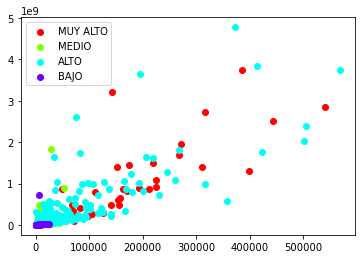

In [34]:
#groups = [(20, 20, "grupo1"), (80, 40, "grupo2"), (200, 200, "grupo3")]
#df = generate_df(groups, 50)
scatter_group_by("images/groups.png", df, "Usuarios", "Consumo", "gdh")

In [29]:
a = [x[0][0] for x in kn]

In [35]:
list_t = [
    (np.array(tuples[0:1]), tuples[2])
    for tuples in df.itertuples(index=False, name=None)
]
points = [point for point, _ in list_t]
labels = [label for _, label in list_t]

usuarios = df_uyc.loc[(df_uyc['Tarifa'] == 'TOTAL') & (df_uyc['Periodo'] == 2017)]['Usuarios'].tolist()
consumo = df_uyc.loc[(df_uyc['Tarifa'] == 'TOTAL') & (df_uyc['Periodo'] == 2017)]['Consumo'].tolist()

input_data = [np.array([x, y]) for x, y in zip(usuarios, consumo)]

kn = k_nearest_neightbors(
    points,
    labels,
    input_data,
    5,
)

In [42]:
dict_results = {
    "usuarios": usuarios,
    "consumo": consumo,
    "gdh": [x[0][0] for x in kn]
}
df_results = pd.DataFrame.from_dict(dict_results)

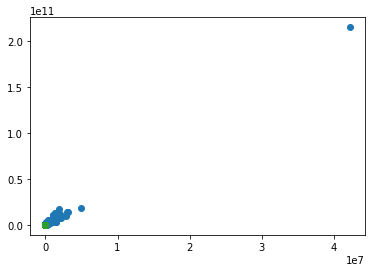

In [43]:
for gdh in df_results['gdh'].unique():
    xp = df_results.loc[(df_results["gdh"] == gdh)]["usuarios"]
    yp = df_results.loc[(df_results["gdh"] == gdh)]["consumo"]
    plt.scatter(xp, yp)
plt.savefig("images/knn.png")
plt.show()
plt.close()

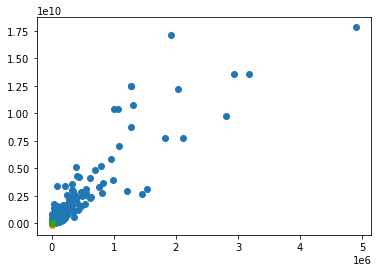

In [44]:
for gdh in df_results['gdh'].unique():
    xp = df_results.loc[(df_results["gdh"] == gdh) & (df_results["consumo"] < 2*10**11)]["usuarios"]
    yp = df_results.loc[(df_results["gdh"] == gdh) & (df_results["consumo"] < 2*10**11)]["consumo"]
    plt.scatter(xp, yp)
plt.savefig("images/knn.png")
plt.show()
plt.close()

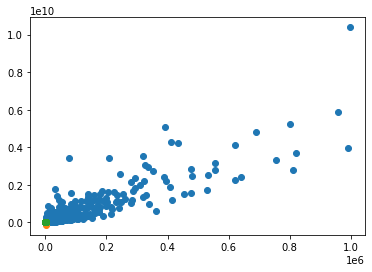

In [46]:
for gdh in df_results['gdh'].unique():
    xp = df_results.loc[(df_results["gdh"] == gdh) & (df_results["usuarios"] < 10**6)]["usuarios"]
    yp = df_results.loc[(df_results["gdh"] == gdh) & (df_results["usuarios"] < 10**6)]["consumo"]
    plt.scatter(xp, yp)
plt.savefig("images/knn.png")
plt.show()
plt.close()